In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# get the .cvs data
raw_data = pd.read_csv('network_backup_dataset.csv')

# find unique days and workflow
work_flows = np.sort(raw_data['Work-Flow-ID'].unique()) # 4 work flows
Day_of_Week =  raw_data['Day of Week'].unique() 
files = np.array(['File_{0}'.format(i) for i in range(len(raw_data['File Name'].unique()))],dtype=object)
row_num, col_num = raw_data.shape

#add one more day# col 
raw_data['day#'] = pd.Series([(row['Week #'] -1 )*7 + 1 +
                              np.where(Day_of_Week == row['Day of Week'])[0][0] 
                              for i, row in raw_data.iterrows()])

In [2]:
# empty X
X = np.zeros([raw_data.shape[0],5])

# create dict for 3 features
weekday_dict = dict(zip(Day_of_Week, range(Day_of_Week.shape[0])))
workflow_dict = dict(zip(work_flows, range(work_flows.shape[0])))
files_dict = dict(zip(files, range(files.shape[0])))

# create scalar feature dataframe
scalar_data = raw_data.replace({'Day of Week': weekday_dict,
                                'Work-Flow-ID':workflow_dict,
                                'File Name': files_dict})

# convert scalar dataframe to np matrix
X = scalar_data.iloc[:,:5].values
y = scalar_data.iloc[:,5].values

## KNN

In [3]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_validate

# optimize parameter
ks = range(1,20)

# empty 2D rmse error

rmse_test = []
rmse_train = []

for k in ks:
    # noneed for encoding 
    
    # regresion model
    model = KNeighborsRegressor(n_neighbors=k)

    # validation score for each fold
    cv_results = cross_validate(model, X, y, 
                                return_train_score=True,
                                scoring='neg_mean_squared_error')

    rmse_test.append(   np.sqrt(np.average( -cv_results['test_score']  )))
    rmse_train.append(  np.sqrt(np.average( -cv_results['train_score'] )))
    

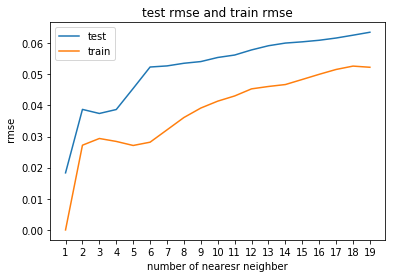

Best k :  1
Corresponding Min RMSE =  0.018331464302376928


In [4]:
# plot 32 models
plt.plot(ks,rmse_test)
plt.plot(ks,rmse_train)
plt.ylabel(' rmse')
plt.xlabel('number of nearesr neighber')
plt.title('test rmse and train rmse')
plt.legend(['test','train'])
plt.savefig('Figures/Question2_e_knn.png')  # Save the figure
plt.xticks(ks)
plt.show()

# find the k with best error
print("Best k : ",ks[np.argmin(rmse_test)])
print("Corresponding Min RMSE = ",np.amin(rmse_test) )


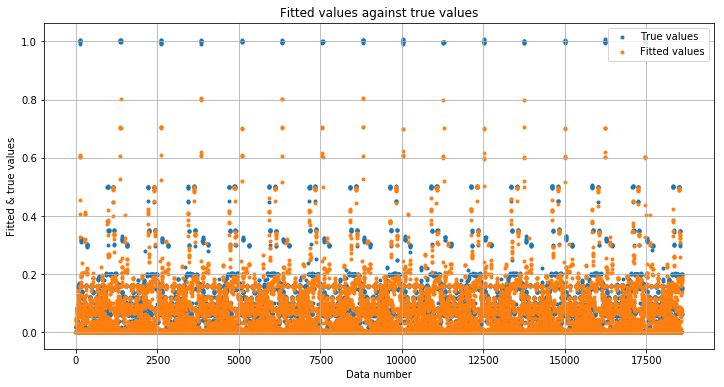

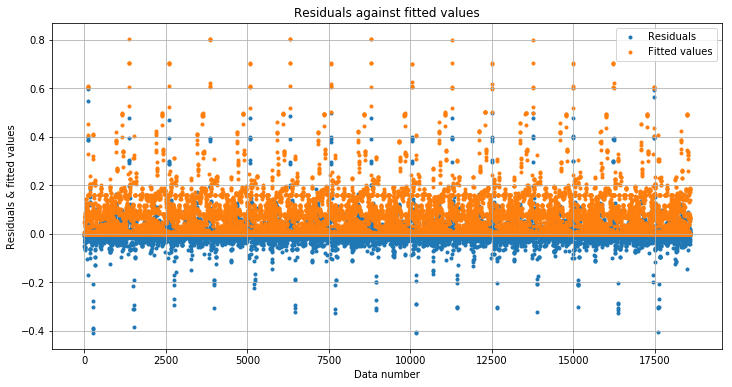

In [5]:
# Use the whole data set for training
model_whole = KNeighborsRegressor(n_neighbors=10)
model_whole.fit(X, y)
predict_values = model_whole.predict(X)

# Plot fitted values against true values
plt.figure(figsize=(12, 6))
plt.title("Fitted values against true values")
plt.scatter(range(1, y.shape[0] + 1), y, marker='.', label='True values')
plt.scatter(range(1, y.shape[0] + 1), predict_values, marker='.', label='Fitted values')
plt.xlabel('Data number')
plt.ylabel('Fitted & true values')
plt.grid()
plt.legend()
plt.savefig('Figures/Question2_e_fitted.png')  # Save the figure
plt.show()

# Plot residuals against fitted values
plt.figure(figsize=(12, 6))
plt.title("Residuals against fitted values")
plt.scatter(range(1, y.shape[0] + 1), y - predict_values, marker='.', label='Residuals')
plt.scatter(range(1, y.shape[0] + 1), predict_values, marker='.', label='Fitted values')
plt.xlabel('Data number')
plt.ylabel('Residuals & fitted values')
plt.grid()
plt.legend()
plt.savefig('Figures/Question2_e_residuals.png')  # Save the figure
plt.show()

## workflow seperately

### create np matrix for each workflow

In [6]:
# craete empty array for each work flow
X_workflows = dict(zip([0,1,2,3,4],[[0 ,0, 0, 0, 0,0]]*5 ))

# seperate the workflow from scalar_data 
X_scalar = scalar_data.values

for row in X_scalar:
    X_workflows[row[3]] = np.vstack((X_workflows[int(row[3])],row[:6]))

/Users/shuangyu/ECE219_projects/.env/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


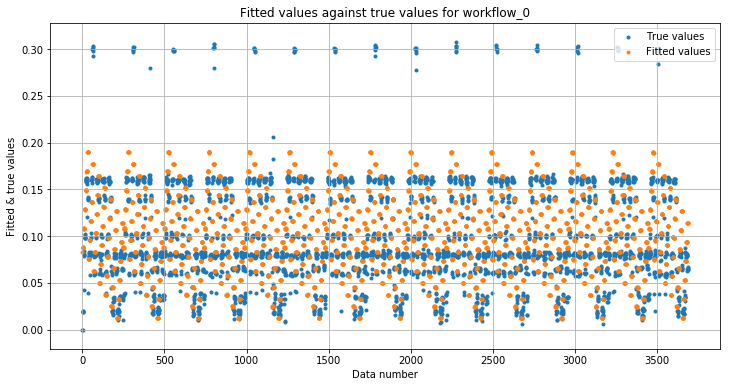

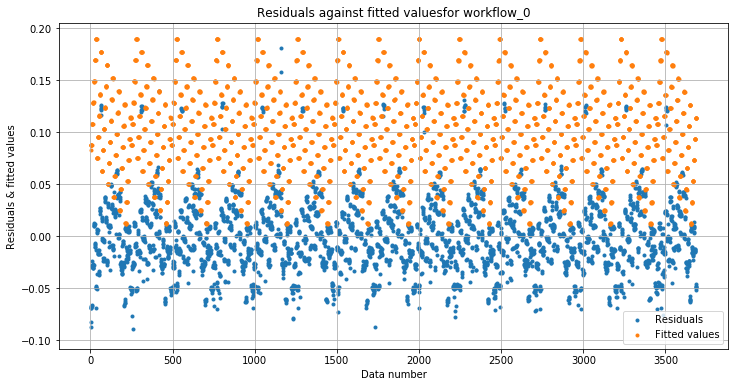

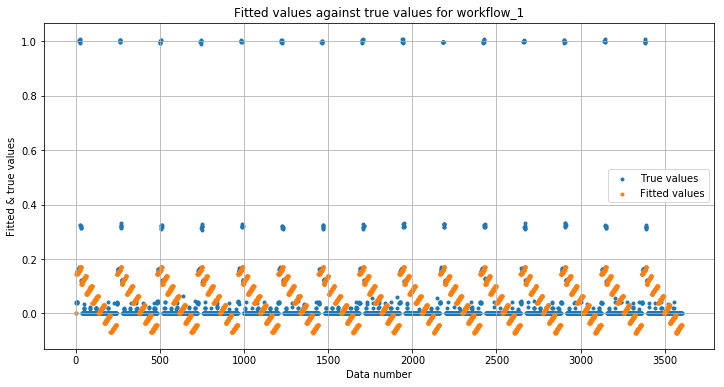

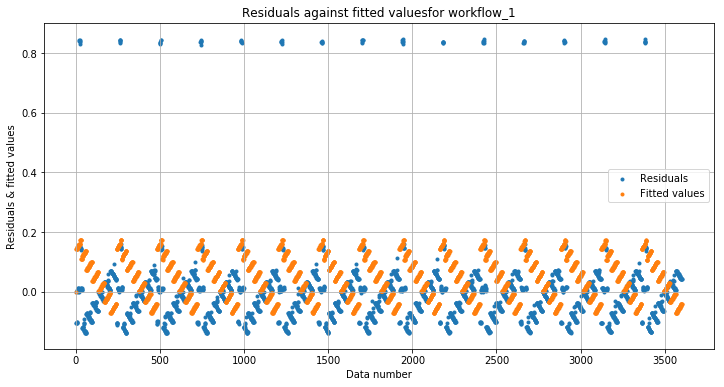

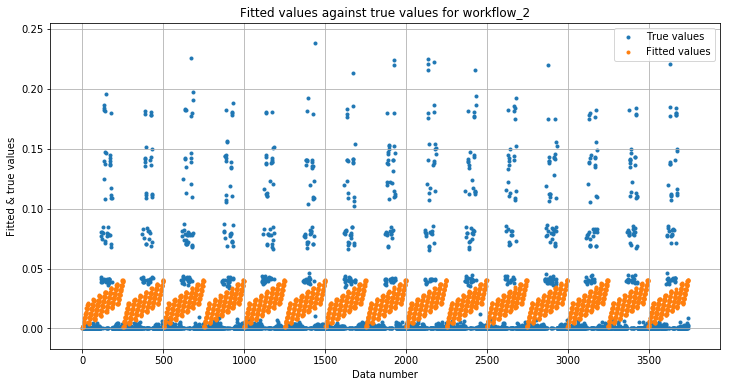

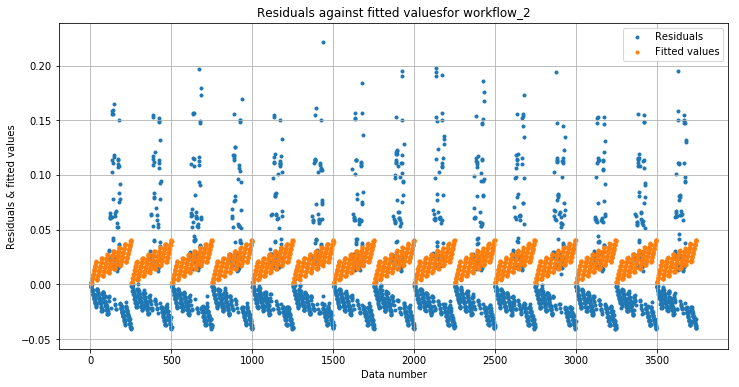

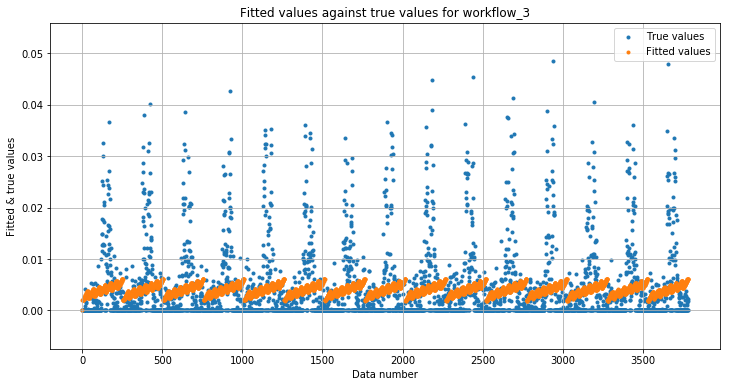

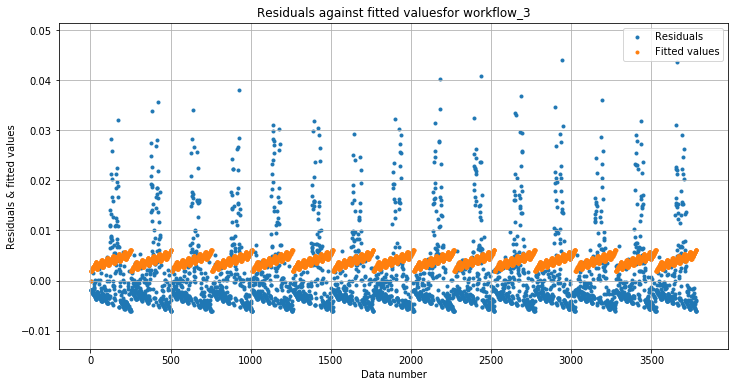

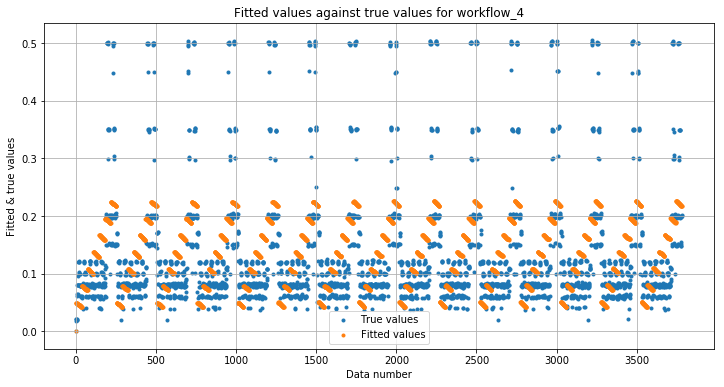

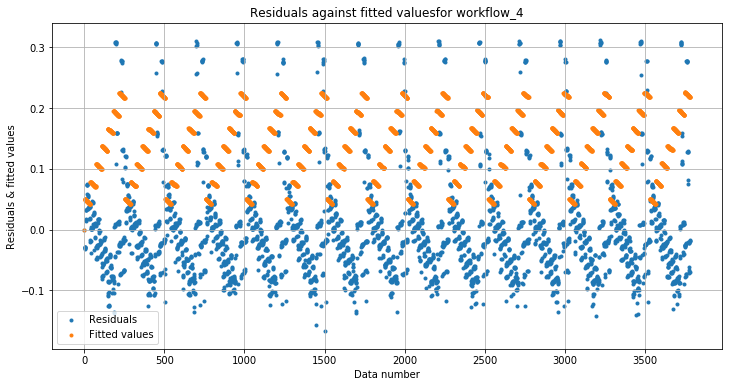

In [7]:
from sklearn.linear_model import LinearRegression
    
rmse_test = []
rmse_train = []
    
# cv to see the linear regression result
for key,workflow in X_workflows.items():
    X_sep = workflow[:,:5]
    y_sep = workflow[:,5]
    
    #in case need to report cv rmse
    model = LinearRegression()
    cv_results = cross_validate(model, X_sep, y_sep, 
                                return_train_score=True,
                                scoring='neg_mean_squared_error')
    
    # save test-score for each workflow 
    rmse_test.append(   np.sqrt(np.average( -cv_results['test_score']  )))
    rmse_train.append(  np.sqrt(np.average( -cv_results['train_score'] )))
    
    # Use the whole data set for training
    model_whole = LinearRegression()
    model_whole.fit(workflow[:, 0:5], workflow[:, 5])
    predict_values = model_whole.predict(workflow[:, 0:5])
    
    # Plot fitted values against true values
    plt.figure(figsize=(12, 6))
    plt.title("Fitted values against true values for workflow_{}".format(key))
    plt.scatter(range(1, workflow.shape[0] + 1), workflow[:, 5], marker='.', label='True values')
    plt.scatter(range(1, workflow.shape[0] + 1), predict_values, marker='.', label='Fitted values')
    plt.xlabel('Data number')
    plt.ylabel('Fitted & true values')
    plt.grid()
    plt.legend()
    plt.savefig('Figures/Question2_d_i_fitted_workflow{}.png'.format(key))  # Save the figure
    plt.show()

    # Plot residuals against fitted values
    plt.figure(figsize=(12, 6))
    plt.title("Residuals against fitted valuesfor workflow_{}".format(key))
    plt.scatter(range(1, workflow.shape[0] + 1), workflow[:, 5] - predict_values, marker='.', label='Residuals')
    plt.scatter(range(1, workflow.shape[0] + 1), predict_values, marker='.', label='Fitted values')
    plt.xlabel('Data number')
    plt.ylabel('Residuals & fitted values')
    plt.grid()
    plt.legend()
    plt.savefig('Figures/Question2_d_i_residuals_workflow{}.png'.format(key))  # Save the figure
    plt.show()

In [8]:
#RMSE for each workflow
print("RMSE for each workflow in TEST:", rmse_test)

print("RMSE for each workflow in TRAIN:", rmse_train)

RMSE for each workflow in TEST: [0.03586198881981263, 0.14877231295247528, 0.042921141140436825, 0.007245350275393028, 0.08593821680923319]
RMSE for each workflow in TRAIN: [0.03585857176071605, 0.14875275424136503, 0.04290977640154784, 0.007243571732649243, 0.08591156984175183]


### for differnt degree

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# work_flow * polynomial 
rmse_test = []
rmse_train = []
    
degrees = range(1,7)
# cv to see the linear regression result
for key,workflow in X_workflows.items():
    X_sep = workflow[:,:5]
    y_sep = workflow[:,5]
    
    rmse_test_degree = []
    rmse_train_degree = []
    for degree in degrees:
        poly = PolynomialFeatures(degree)
        X_poly = poly.fit_transform(X_sep)
        
        # regresion model
        model = LinearRegression()

        # validation score for each fold
        cv_results = cross_validate(model, X_poly, y_sep, 
                                    return_train_score=True,
                                    scoring='neg_mean_squared_error')

        rmse_test_degree.append(   np.sqrt(np.average( -cv_results['test_score']  )))
        rmse_train_degree.append(  np.sqrt(np.average( -cv_results['train_score'] )))
        
        
    rmse_test.append(rmse_test_degree)
    rmse_train.append(rmse_train_degree)


    

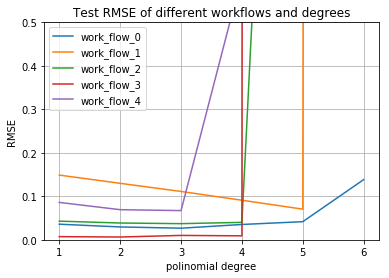

In [10]:
# plot for test
# change to np array # rmse_test = work_flow * polynomial
rmse_test_array = np.array(rmse_test).T

plt.figure()
plt.title("Test RMSE of different workflows and degrees")
plt.plot(degrees, rmse_test_array)

plt.xlabel('polinomial degree')
plt.ylabel('RMSE')
plt.grid()
plt.legend(work_flows)
plt.xticks(degrees)
plt.ylim((0,0.5))
plt.savefig('Figures/Question2_d_ii_different_degree_TEST.png')  # Save the figure
plt.show()
        
        



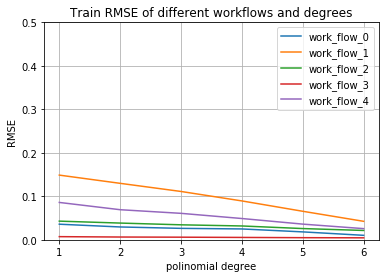

In [11]:
# plot for train
# change to np array # rmse_test = work_flow * polynomial 
rmse_train_array = np.array(rmse_train).T

plt.figure()
plt.title('Train RMSE of different workflows and degrees')
plt.plot(degrees,rmse_train_array)

plt.xlabel('polinomial degree')
plt.ylabel('RMSE')
plt.grid()
plt.legend(work_flows)
plt.xticks(degrees)
plt.savefig('Figures/Question2_d_ii_different_degree_Train.png')  # Save the figure
plt.ylim((0,0.5))
plt.show()
        

### plot with best degree

In [14]:
for i in range(len(rmse_test)):
    print('the best degree is :', np.argmin(rmse_test[i])+1)
    print("The min test RMSE for workflow_{} is {} ".format(i,np.amin(rmse_test[i])))
print('-'*10)
for i in range(len(rmse_train)):
    print("The min train RMSE for workflow_{} is {} ".format(i,np.amin(rmse_train[i])))

the best degree is : 3
The min test RMSE for workflow_0 is 0.026673117261153338 
the best degree is : 5
The min test RMSE for workflow_1 is 0.0704479992574137 
the best degree is : 3
The min test RMSE for workflow_2 is 0.03711667514264777 
the best degree is : 2
The min test RMSE for workflow_3 is 0.006412684458661681 
the best degree is : 3
The min test RMSE for workflow_4 is 0.06713983905481843 
----------
The min train RMSE for workflow_0 is 0.010295558081478275 
The min train RMSE for workflow_1 is 0.0424956178789225 
The min train RMSE for workflow_2 is 0.021485893199284116 
The min train RMSE for workflow_3 is 0.0045530456777495175 
The min train RMSE for workflow_4 is 0.025680915343315236 


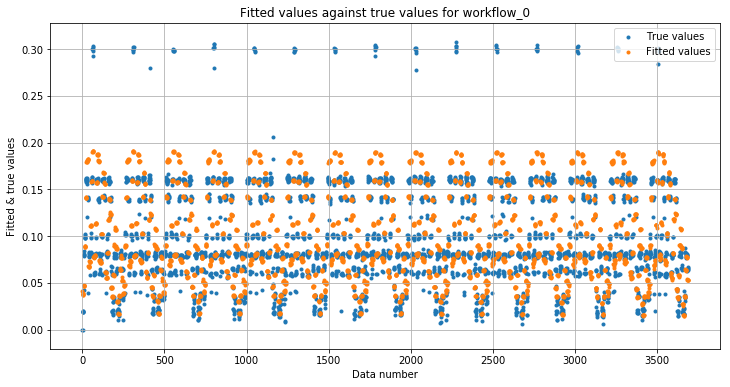

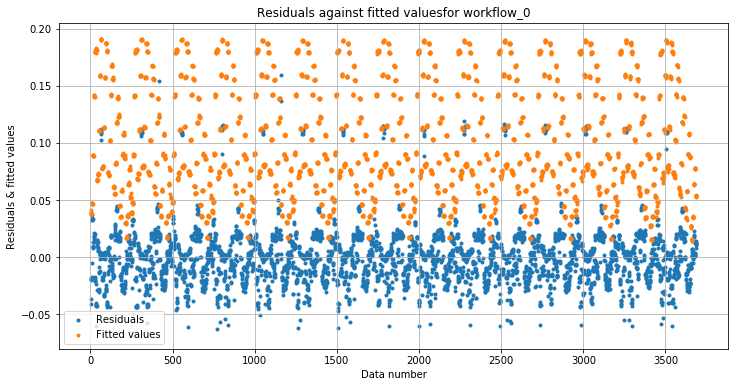

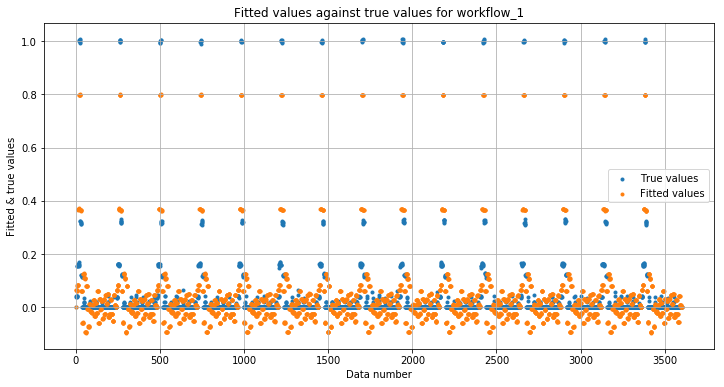

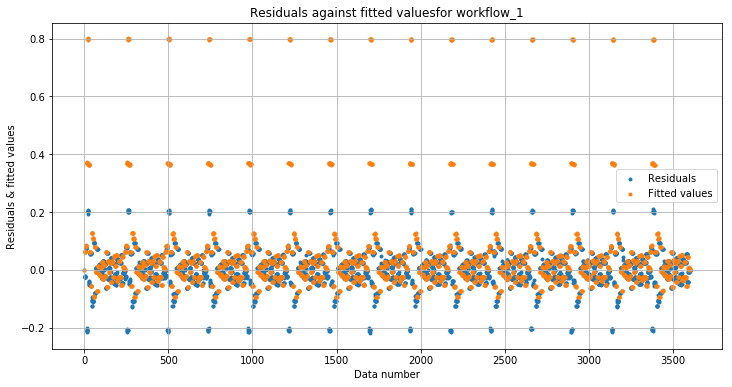

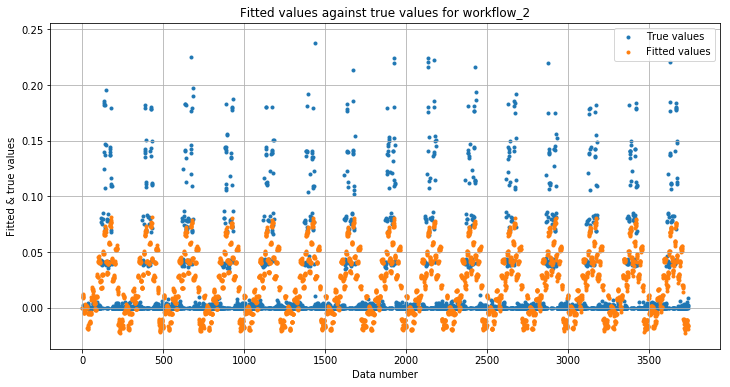

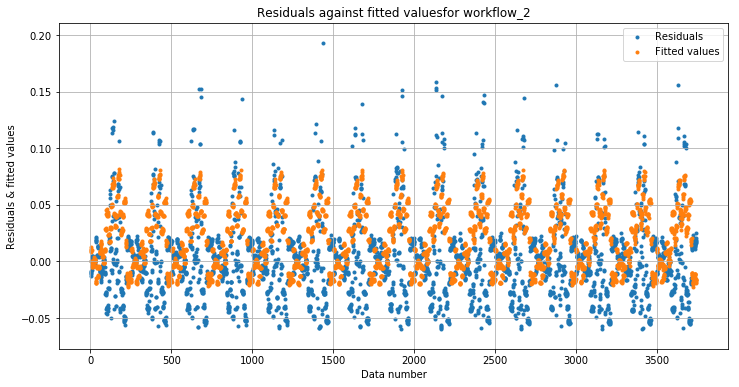

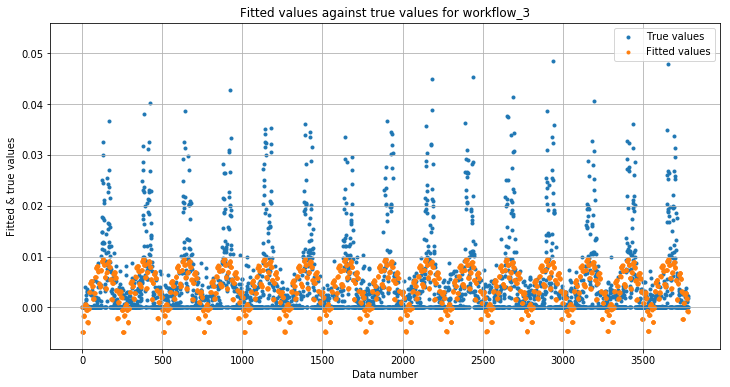

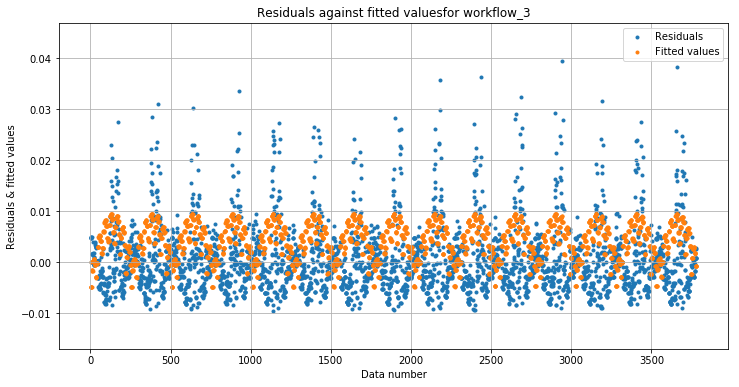

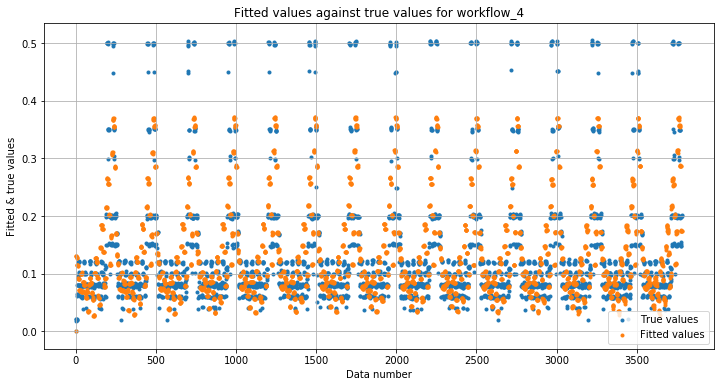

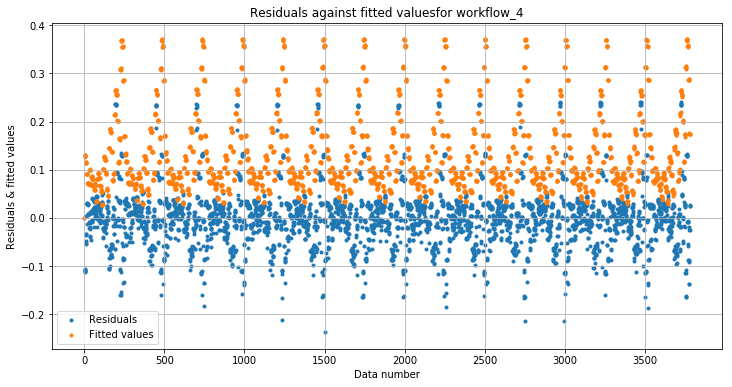

In [13]:
from sklearn.linear_model import LinearRegression
    

# cv to see the linear regression result
for key,workflow in X_workflows.items():
    X_sep = workflow[:,:5]
    y_sep = workflow[:,5]
    
    poly = PolynomialFeatures(np.argmin(rmse_test[key])+1)
    X_poly = poly.fit_transform(X_sep)
    
    # Use the whole data set for training
    model_whole = LinearRegression()
    model_whole.fit(X_poly, y_sep)
    predict_values = model_whole.predict(X_poly)
    
    # Plot fitted values against true values
    plt.figure(figsize=(12, 6))
    plt.title("Fitted values against true values for workflow_{}".format(key))
    plt.scatter(range(1, y_sep.shape[0] + 1), y_sep, marker='.', label='True values')
    plt.scatter(range(1, y_sep.shape[0] + 1), predict_values, marker='.', label='Fitted values')
    plt.xlabel('Data number')
    plt.ylabel('Fitted & true values')
    plt.grid()
    plt.legend()
    plt.savefig('Figures/Question2_d_ii_fitted_workflow{}.png'.format(key))  # Save the figure
    plt.show()

    # Plot residuals against fitted values
    plt.figure(figsize=(12, 6))
    plt.title("Residuals against fitted valuesfor workflow_{}".format(key))
    plt.scatter(range(1, y_sep.shape[0] + 1), y_sep - predict_values, marker='.', label='Residuals')
    plt.scatter(range(1, y_sep.shape[0] + 1), predict_values, marker='.', label='Fitted values')
    plt.xlabel('Data number')
    plt.ylabel('Residuals & fitted values')
    plt.grid()
    plt.legend()
    plt.savefig('Figures/Question2_d_ii_residuals_workflow{}.png'.format(key))  # Save the figure
    plt.show()